In [2]:
import random
from ase import Atoms
from ase.io import Trajectory
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import csv
import os

from mdsim.datasets.lmdb_dataset import LmdbDataset

random.seed(88)

In [2]:
# copied this over from ase_utils
def data_to_atoms(data):
    numbers = data.atomic_numbers
    positions = data.pos
    cell = data.cell.squeeze()
    atoms = Atoms(numbers=numbers.cpu().detach().numpy(), 
                  positions=positions.cpu().detach().numpy(), 
                  cell=cell.cpu().detach().numpy(),
                  pbc=[True, True, True])
    return atoms

def get_overall_energy(atoms):
    """
    Calculate the overall energy of the system from the elements and their respective energies.
    """
    # list of valid elements and their respective energies
    valid_elem = {35: -70045.28385080204,  # Br
                  6: -1030.5671648271828,  # C
                  17: -12522.649269035726,  # Cl
                  9: -2715.318528602957,  # F
                  1: -13.571964772646918,  # H
                  53: -8102.524593409054,  # I
                  7: -1486.3750255780376,  # N
                  8: -2043.933693071156,  # O
                  15: -9287.407133426237,  # P
                  16: -10834.4844708122}  # S
    
    total = 0
    for an in atoms.get_atomic_numbers():
        if an in valid_elem:
            total += valid_elem[an]
    return total

In [3]:
def get_atoms(from_dataset, init_idx=None):
    if from_dataset:
        # get the molecule from the dataset
        # test_dataset = LmdbDataset({'src': '/data/shared/md17/aspirin/10k/test'})
        test_dataset = LmdbDataset({'src': '/data/shared/MLFF/SPICE/maceoff_split/test'})
        if init_idx is None:
            init_idx = random.randint(0, len(test_dataset))
        init_data = test_dataset[init_idx]
        atoms = data_to_atoms(init_data)
        print(f"reference energy {init_data.reference_energy}")
    else:
        # get atoms from the trajectory file from the simulation
        md_dir = Path('../MODELPATH/maceoff_split_gemnet_dT_results/md_25ps_123_init_8888')
        traj = Trajectory(md_dir / 'atoms.traj')
        atoms = traj[1] # gets unstable very quick
    print(f'overall energy from atoms {get_overall_energy(atoms)}')
    return atoms

In [8]:
test_dataset = LmdbDataset({'src': '/data/shared/MLFF/SPICE/maceoff_split/test'})
seen = set()
with open('num_atoms_leq_15.txt', 'w') as f:
    for i in range(len(test_dataset)):
        init_data = test_dataset[i]
        atoms = data_to_atoms(init_data)
        if init_data.atomic_numbers.shape[0] <= 15 and len(str(atoms.symbols)) > 6 and str(atoms.symbols) not in seen:
            seen.add(str(atoms.symbols))
            f.write(f'{i} {str(atoms.symbols)}\n')

In [4]:
atoms = get_atoms(from_dataset=True, init_idx=25804)

reference energy tensor([-219.3464], dtype=torch.float64)
overall energy from atoms -104400.36756830433


In [20]:
test_dataset = LmdbDataset({'src': '/data/shared/MLFF/SPICE/maceoff_split/test'})
result = {}
with open ('num_atoms_leq_15.txt', 'r') as f:
    for line in f:
        num = int(line.split()[0].strip())
        init_data = test_dataset[num]
        result[init_data.dataset_name] = result.get(init_data.dataset_name, 0) + 1
print(result)

{'DES370K Dimers': 303, 'PubChem': 405, 'DES370K Monomers': 28}


In [30]:
df = pd.read_csv('records_gemnet_fulldt_maceoff.csv')
column_values = df['init_idx'].tolist()

test_dataset = LmdbDataset({'src': '/data/shared/MLFF/SPICE/maceoff_split/test'})
result = {}
res_with_names = {}
for num in column_values:
    init_data = test_dataset[num]
    result[init_data.dataset_name] = result.get(init_data.dataset_name, 0) + 1
    atoms = data_to_atoms(init_data)
    if init_data.dataset_name not in res_with_names:
        res_with_names[init_data.dataset_name] = [str(atoms.symbols)]
    else:
        res_with_names[init_data.dataset_name].append(str(atoms.symbols))
print(result)
print(res_with_names)

{'DES370K Dimers': 3, 'DES370K Monomers': 52, 'water': 1, 'PubChem': 30}
{'DES370K Dimers': ['SH2SH2', 'CH4OH2', 'NCHOH2'], 'DES370K Monomers': ['ClC4H9', 'NC3H9', 'C6H12', 'C6H10', 'F2C6H4', 'C8NH7', 'F3C2H3', 'SC4H10', 'NC5H13', 'C2H2', 'BrC2H5', 'SC4H8', 'S2H2', 'NCH', 'C5H12', 'O2C4H8', 'C8NCH9', 'BrCH3', 'Cl2CH2', 'OC3H8', 'SC2H6', 'Cl6C6', 'C7H14', 'SC3H8', 'C4H6', 'Br2CH2', 'BrC6H5', 'C4H10', 'FC6H5', 'F3C6H3', 'F2C4H8', 'NCH5', 'F2C2H4', 'Cl3CH', 'C3H8', 'C4NH5', 'SH2', 'FC4H9', 'OC6H6', 'OC3H6', 'OC4H8', 'F6C6', 'I2C2H4', 'F2CH2', 'I2CH2', 'SCH4', 'ClC6H5', 'OC5H10', 'NC4H7', 'C2H4', 'F3C3H5', 'Cl5C6H'], 'water': ['O3H6'], 'PubChem': ['C16H24', 'C20H24', 'Cl8C10', 'O2C9H6', 'N2F4C8', 'C11H12', 'OSC4H4', 'F6N2C8', 'C8H8', 'C8H14', 'NC5NH4', 'N2F6C6', 'NC8H19', 'F4S2C2', 'F3BrC3', 'F4I2C6', 'OC8H10', 'NC9H13', 'O3C5H4', 'F6N4C4', 'Br6C2', 'NSC6H9', 'C15H26', 'C21H12', 'C12H22', 'Br4C2', 'Cl8C8', 'ClC7H9', 'C22H16', 'F20C12']}


In [7]:
test_dataset = LmdbDataset({'src': '/data/shared/MLFF/SPICE/maceoff_split/test'})
df = pd.read_csv('test_set_losses.csv')
result = {}

for row in df.itertuples(index=False):  # set index=False if you don’t need the row index
    num = row.init_idx
    init_data = test_dataset[num]
    if init_data.dataset_name not in result:
        result[init_data.dataset_name] = [row[2]]
    else:
        result[init_data.dataset_name].append(row[2])
        
print(result)

{'PubChem': [21.833785417532454, 19.305620085415523, 12.843624379110045, 56.08224096342229, 13.540822203633262, 38.53189197187283, 15.901425457814558, 30.705394093630588, 15.360387063466009, 23.307763918242312, 26.72970689008471, 31.095849039478725, 26.34844976956542, 21.93399780100781, 17.316888835553115, 26.80769335431642, 31.9355015642609, 20.32001112320661, 28.74877585569144, 9.47879679771276, 31.19103477254872, 8.122406452452545, 14.57426528617777, 16.030776638171947, 10.21971520998972, 12.622501160569692, 13.100343911782607, 26.93893701442149, 9.835747323538858, 12.32154867382408, 16.672292686881143, 14.416967349606802, 195.08310648581408, 24.053242446391323, 11.01604840338361, 27.118945127483645, 12.733742679293426, 30.74863132563964, 12.38083254756458, 15.485158003558784, 12.002800355267576, 15.571477331788556, 15.047483720276135, 12.016205295956471, 28.045629697327215, 26.26054657658857, 34.127200208429755, 15.133644853692577, 15.985127059917822, 30.25042303148532, 24.86904585

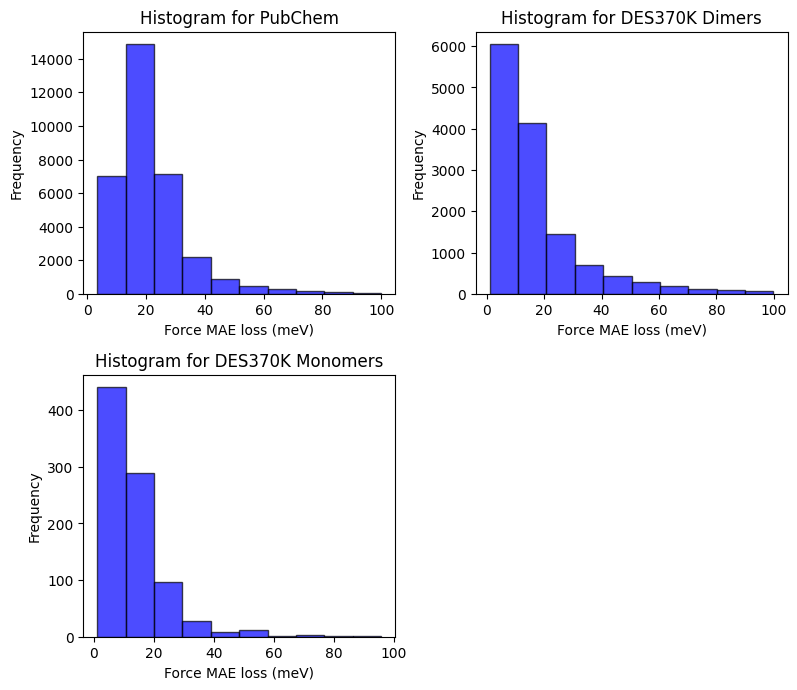

In [29]:
# Define the number of rows and columns for the grid
n_rows, n_cols = 3, 3  # 3x3 grid

# Create the subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 10))

# Flatten axes for easy iteration (it’s a 2D array)
axes = axes.flatten()
desired = ['PubChem', 'DES370K Dimers', 'DES370K Monomers']

# Plot each histogram
for i, (key, values) in enumerate(result.items()):
    if key in desired:
        axes[i].hist([v for v in values if v < 100], bins=10, alpha=0.7, color='blue', edgecolor='black')
        axes[i].set_title(f'Histogram for {key}')
        axes[i].set_xlabel('Force MAE loss (meV)')
        axes[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])  # Remove extra axes

fig.delaxes(axes[2])
fig.delaxes(axes[4])
fig.delaxes(axes[5])
fig.delaxes(axes[6])

plt.tight_layout()  # Adjust spacing
plt.show()

In [ ]:
test_dataset = LmdbDataset({'src': '/data/shared/MLFF/SPICE/maceoff_split/test'})
with open('test_set_losses.txt', 'r') as file:
    numbers = [int(line.strip()) for line in file]
    
seen = set()
with open('least_force_loss_molecules.txt', 'w') as f:
    for num in numbers:
        init_data = test_dataset[num]
        atoms = data_to_atoms(init_data)
        if str(atoms.symbols) not in seen:
            f.write(f'{num} {str(atoms.symbols)}\n')
            seen.add(str(atoms.symbols))
    
print(len(seen))
print(seen)

In [3]:
def get_idxs_of_datasets(dataset_name):
    test_dataset = LmdbDataset({'src': f'/data/shared/MLFF/SPICE/maceoff_split/{dataset_name}'})
    dataset_to_idxs = {}

    for idx in tqdm(range(len(test_dataset))):
        init_data = test_dataset[idx]
        if init_data.dataset_name not in dataset_to_idxs:
            dataset_to_idxs[init_data.dataset_name] = [idx]
        else:
            dataset_to_idxs[init_data.dataset_name].append(idx)
    
    return dataset_to_idxs

In [4]:
test_dataset_to_idxs = get_idxs_of_datasets('test')
print({key: len(test_dataset_to_idxs[key]) for key in test_dataset_to_idxs.keys()})

100%|██████████| 50194/50194 [00:13<00:00, 3611.57it/s]

{'DES370K Dimers': 13907, 'PubChem': 34093, 'DES370K Monomers': 889, 'Dipeptides': 1025, 'QMugs': 144, 'water': 84, 'Solvated Amino Acids': 52}


In [23]:
prev = None
for i in range(52):
    idx = test_dataset_to_idxs['Solvated Amino Acids'][i]
    init_data = test_dataset[idx]
    atoms = data_to_atoms(init_data)
    if str(atoms.symbols) == 'O2C2N2C7H18OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2':
        if prev is not None:
            print(prev)
            print(idx)
        prev = idx

17789
18343
18343
41430
41430
43037
43037
48992


In [5]:
np.random.seed(88)
test_50_each = {}
for key in test_dataset_to_idxs.keys():
    test_50_each[key] = np.random.choice(test_dataset_to_idxs[key], min(100, len(test_dataset_to_idxs[key])), replace=False)
{key: len(test_50_each[key]) for key in test_50_each.keys()}

{'DES370K Dimers': 100,
 'PubChem': 100,
 'DES370K Monomers': 100,
 'Dipeptides': 100,
 'QMugs': 100,
 'water': 84,
 'Solvated Amino Acids': 52}

In [7]:
new_50_each = {key: [] for key in test_50_each.keys()}
seen_test = set()
test_dataset = LmdbDataset({'src': f'/data/shared/MLFF/SPICE/maceoff_split/test'})
for key in test_50_each.keys():
    for i in range(len(test_50_each[key])):
        idx = test_50_each[key][i]
        init_data = test_dataset[idx]
        atoms = data_to_atoms(init_data)
        if str(atoms.symbols) not in seen_test and len(new_50_each[key]) < 50:
            new_50_each[key].append([idx, str(atoms.symbols), 'test'])
            seen_test.add(str(atoms.symbols))

{key: len(new_50_each[key]) for key in new_50_each.keys()}

{'DES370K Dimers': 50,
 'PubChem': 50,
 'DES370K Monomers': 50,
 'Dipeptides': 50,
 'QMugs': 50,
 'water': 13,
 'Solvated Amino Acids': 16}

In [24]:
with open('output.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['dataset', 'init_idx', 'molecule', 'from_train_or_test'])  # Header row
    
    # Write each entry
    for category, items in new_50_each.items():
        for item in items:
            writer.writerow([category] + item)

In [14]:
train_dataset_to_idxs = get_idxs_of_datasets('train')
print({key: len(train_dataset_to_idxs[key]) for key in train_dataset_to_idxs.keys()})

  0%|          | 0/951004 [00:00<?, ?it/s]

100%|██████████| 951004/951004 [04:02<00:00, 3924.82it/s]


{'DES370K Dimers': 263064, 'PubChem': 646017, 'Dipeptides': 19769, 'water': 1597, 'DES370K Monomers': 16861, 'QMugs': 2748, 'Solvated Amino Acids': 948}


In [52]:
def get_remaining(lst, num):
    res = []
    seen = set()
    train_dataset = LmdbDataset({'src': f'/data/shared/MLFF/SPICE/maceoff_split/train'})
    for i in range(len(lst)):
        idx = lst[i]
        init_data = train_dataset[idx]
        atoms = data_to_atoms(init_data)
        if str(atoms.symbols) not in seen and str(atoms.symbols) not in seen_test and len(res) < num:
            res.append([idx, str(atoms.symbols), 'train'])
            seen.add(str(atoms.symbols))
    return res

In [53]:
water_res = get_remaining(train_dataset_to_idxs['water'], 2000)
saa_res = get_remaining(train_dataset_to_idxs['Solvated Amino Acids'], 2000)
print(len(water_res), len(saa_res))

0 2


In [54]:
saa_res

[[4688,
  'O2C2N2C6H14OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2',
  'train'],
 [25598,
  'O3C3N3C4H13OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2OH2',
  'train']]

In [3]:
# Get unique 'dataset' entries as a list
spice_molecules_set = pd.read_csv('spice_molecules_set.csv')
unique_datasets = spice_molecules_set['dataset'].unique().tolist()
print(unique_datasets)

['DES370K Dimers', 'PubChem', 'DES370K Monomers', 'Dipeptides', 'QMugs', 'water', 'Solvated Amino Acids']


In [10]:
# 36980 is stable for gemnet t
# not: 45000, 7857, 18282
# wow none of these are stable for gemnet-dt
thresh = 20
in_thresh = {dataset: [] for dataset in unique_datasets}
out_thresh = {dataset: [] for dataset in unique_datasets}
df = pd.read_csv('records_spice_molecules_set/gemnet_dt_full.csv')
init_idxs = df['init_idx'].tolist()
for init_idx in init_idxs[:-2]:
    row = spice_molecules_set.loc[spice_molecules_set['init_idx'] == init_idx]
    dataset = row['dataset'].values[0]
    
    md_dir = Path(f'../MODELPATH/maceoff_split_gemnet_dT_full/md_25ps_123_init_{init_idx}')
    # md_dir = Path(f'../MODELPATH/spice_all_gemnet_t_maceoff_split_mine/md_25ps_123_init_{init_idx}')
    traj = Trajectory(md_dir / 'atoms.traj')
    
    val = np.max(np.abs(np.roll(traj[-1].get_positions(), 1, axis=0) - traj[-1].get_positions()))
    if val < thresh:
        in_thresh[dataset].append(init_idx)
        # print(init_idx, val)
    else:
        out_thresh[dataset].append(init_idx)
        # print(init_idx, val)

print("IN THRESH")
for key, value in in_thresh.items():
    print(f"{key}: {len(value)}")
print("\nOUT THRESH")
for key, value in out_thresh.items():
    print(f"{key}: {len(value)}")

IN THRESH
DES370K Dimers: 0
PubChem: 22
DES370K Monomers: 35
Dipeptides: 49
QMugs: 44
water: 0
Solvated Amino Acids: 0

OUT THRESH
DES370K Dimers: 30
PubChem: 0
DES370K Monomers: 0
Dipeptides: 0
QMugs: 0
water: 0
Solvated Amino Acids: 0


In [6]:
test_dataset = LmdbDataset({'src': f'/data/shared/MLFF/SPICE/maceoff_split/test'})
for idx in in_thresh['QMugs']:
    init_data = test_dataset[idx]
    atoms = data_to_atoms(init_data)
    print(init_data.dataset_name, idx, str(atoms.symbols), init_data.pos.shape[0])

Dipeptides 35799 O4C4N4C9H24 45
Dipeptides 40359 O6C10N3C7H23 49
Dipeptides 24423 O3SC3N3C11H27 48
Dipeptides 24423 O3SC3N3C11H27 48
Dipeptides 45129 O4C4N4C6H18 36
Dipeptides 14275 O6C5N4C7H20 42
Dipeptides 34423 O4C4N5C10H27 50
Dipeptides 6846 O4C3N4C9H24 44
Dipeptides 50175 O3NC14N5C6H24 53
Dipeptides 36580 O6C4N3C7H19 39
Dipeptides 6426 O5C4N3C10H25 47
Dipeptides 96 O3NC6N4C8H21 43
Dipeptides 29172 O3C9N3C9H27 51
Dipeptides 46338 O5C4N3C6H17 35
Dipeptides 19337 O5C10N4C7H24 50
Dipeptides 20340 O4C3N3C9H23 42
Dipeptides 2994 O4SC4N4C8H22 43
Dipeptides 3875 O3SC3N3C7H19 36
Dipeptides 42209 O3C3N4C11H28 49
Dipeptides 30061 O4C17N4C6H26 57
Dipeptides 46280 O5C4N3C9H23 44
Dipeptides 11496 O3NC6N4C8H23 45
Dipeptides 11510 O4C3N3C9H21 40
Dipeptides 12008 O4C4N4C8H20 40
Dipeptides 14896 O3C3N3C11H25 45
Dipeptides 36883 O5SC4N3C8H21 42
Dipeptides 41561 O4SC4N4C7H20 40
Dipeptides 48500 O3C9N3C6H21 42
Dipeptides 42898 O6C4N3C8H21 42
Dipeptides 14539 O3NC6N4C6H19 39
Dipeptides 12178 O3SC11N4C6

In [5]:
np.random.seed(88)
np.random.choice(in_thresh['DES370K Monomers'], 10, replace=False)

array([  193, 49489, 43692, 22229, 48228, 14423, 32081, 29366, 24134,
       15700])

In [11]:
df = pd.read_csv('records_spice_molecules_set/gemnet_dt_full.csv')
filtered_df = df[df['init_idx'].isin(in_thresh['QMugs'])]
print(np.mean(np.abs(filtered_df['total energy deviation (meV)'])))
filtered_df

6294.992564544403


,molecule,init_idx,traj[0] potential energy,traj[0] kinetic energy,traj[-1] potential energy,traj[-1] kinetic energy,total energy deviation (meV)
136,COC8NC3FC4FCONC3NCOCFH22,4684,-41959.775920,2.157062,-41959.848527,8.228694,5999.024755
137,C3NCOCNC9FC2NC5NC3OH29,16318,-38154.407191,2.378816,-38154.996505,11.388766,8420.635221
138,C7OCOC3NC9ONC2NC5NSNC4H39,42763,-57237.241767,3.031165,-57236.293017,18.836571,16754.156061
139,OCNC9N2C6ClC6FC2FC3NH17,48731,-54265.059251,2.108560,-54265.305940,4.854932,2499.682738
140,C3NCSC2ONC6N2C3NCOC4SH27,16684,-54416.814143,2.295025,-54416.332090,5.746695,3933.723835
141,C7NCNC2NC8NC3ONC2ONC2H28,36736,-39438.860666,2.410227,-39439.238581,8.731942,5943.799454
142,COCOC22NCH29,7715,-31999.976476,2.325528,-31999.988779,8.367560,6029.728805
143,C2NC4NC3NCNC3NCOC6F3C5NC6NCNH33,11840,-55872.777967,2.967935,-55871.387894,10.291095,8713.233950
144,C5NCOCSCN2C3NCO2C4OC3H26,7075,-45131.759955,2.210870,-45131.381154,7.403843,5571.773925
145,OCNC4OC5F3C4NC9ONC3NC2OC2H33,32172,-53979.402584,2.898851,-53979.059034,5.610542,3055.240936


## For MLIP Simulations

In [12]:
# Get unique 'dataset' entries as a list
spice_molecules_set = pd.read_csv('spice_molecules_set.csv')
unique_datasets = spice_molecules_set['dataset'].unique().tolist()
print(unique_datasets)

['DES370K Dimers', 'PubChem', 'DES370K Monomers', 'Dipeptides', 'QMugs', 'water', 'Solvated Amino Acids']


In [20]:
from ase.db import connect

def energy_deviation_from_db(directory, dbname):
    files = sorted(os.listdir(directory))
    category_to_trajs = {dataset: [] for dataset in unique_datasets}
    for file in files:
        for dataset in unique_datasets:
            if dataset in file:
                category_to_trajs[dataset].append(file)
    # print({key: len(category_to_trajs[key]) for key in category_to_trajs.keys()})
    
    thresh = 20
    count = 0
    out_thresh = {dataset: [] for dataset in unique_datasets}
    bad_idxs = []
    for dataset in unique_datasets:
        for fname in category_to_trajs[dataset]:
            path = Path(os.path.join(directory, fname))
            init_idx = int(fname.split('.')[0].split('_')[-1])
            traj = Trajectory(path)
            val = np.max(np.abs(np.roll(traj[-1].get_positions(), 1, axis=0) - traj[-1].get_positions()))
            if val < thresh:
                count += 1
            else:
                out_thresh[f'{dataset}'].append(init_idx)
                bad_idxs.append(init_idx)
    # [(category, len(out_thresh[category])) for category in out_thresh]
    
    categories = ['DES370K Dimers', 'PubChem', 'DES370K Monomers', 'Dipeptides', 'QMugs', 'water', 'Solvated Amino Acids']
    category_to_dev = {category: [] for category in categories}
    prev = None
    with connect(dbname) as db:
        for row in sorted(db.select(), key=lambda x: x['description']):
            curr_split = row['description'].split('_')
            curr_cat = curr_split[1]
            curr_idx = curr_split[2]  # the init_idx of the molecule
            curr_stage = curr_split[3]
            if int(curr_idx) in bad_idxs and curr_stage == 'final':
                print(curr_idx, curr_stage)
                continue
            if prev is not None:
                prev_split = prev['description'].split('_')
                prev_cat = prev_split[1]
                prev_idx = prev_split[2]
                prev_stage = prev_split[3]
                if prev_idx == curr_idx:  # if there is an initial and final of the molecule. note we sorted it alphabetically so final comes before initial
                    assert(curr_stage == 'initial' and prev_stage == 'final')
                    assert(prev_cat == curr_cat)
                    category_to_dev[prev_cat].append(abs(row.energy - prev.energy))
            prev = row
            # print(row.id, row.energy, row['description'])
    print(db.count())
    return category_to_dev

In [21]:
# all the ones that get skipped only have the initial and not the final from yuan
directory = '/home/christine/mlip-arena/CHGNet_sims'
dbname = '/home/christine/mlip-arena/molecules_CHGNet_MPGGA.db'
category_to_dev = energy_deviation_from_db(directory, dbname)
print('CHGNet average absolute energy deviation')
[(category, len(category_to_dev[category]), np.mean(category_to_dev[category])) for category in category_to_dev]

541
CHGNet average absolute energy deviation


[('DES370K Dimers', 46, 0.17472693826086852),
 ('PubChem', 49, 0.5667401210204106),
 ('DES370K Monomers', 50, 0.19525560640000003),
 ('Dipeptides', 50, 0.5532724674000025),
 ('QMugs', 49, 1.4735251912244858),
 ('water', 9, 1.0640936744444487),
 ('Solvated Amino Acids', 11, 3.226036196363633)]

In [22]:
# all the ones that get skipped only have the initial and not the final from yuan (for macemp also)
directory = '/home/christine/mlip-arena/MACE-MP(M)_sims'
dbname = '/home/christine/mlip-arena/molecules_MACE-MP(M)_MPGGA.db'
category_to_dev = energy_deviation_from_db(directory, dbname)
print('MACE-MP(M) average absolute energy deviation')
[(category, len(category_to_dev[category]), np.mean(category_to_dev[category])) for category in category_to_dev]

506
MACE-MP(M) average absolute energy deviation


[('DES370K Dimers', 35, 0.19889913828571296),
 ('PubChem', 47, 0.6024374474468112),
 ('DES370K Monomers', 50, 0.23891157940000038),
 ('Dipeptides', 50, 0.5600788610000013),
 ('QMugs', 46, 1.5004442073913056),
 ('water', 6, 0.5960294166666659),
 ('Solvated Amino Acids', 2, 0.4549073500000098)]

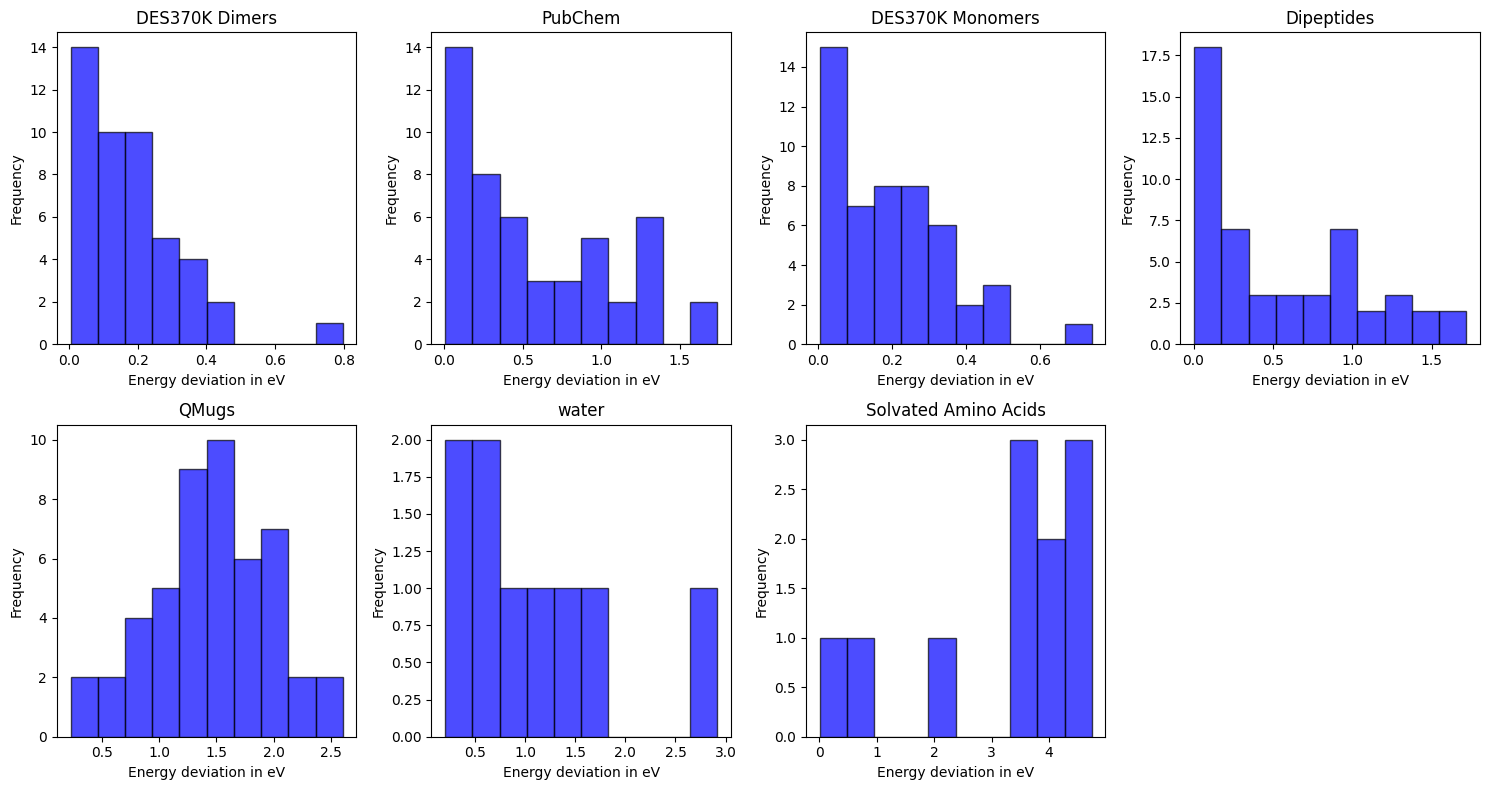

In [17]:
# now get the histogram for each category of molecule
fig, axes = plt.subplots(2, 4, figsize=(15, 8))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each histogram
for idx, (key, values) in enumerate(category_to_dev.items()):
    axes[idx].hist(values, bins=10, alpha=0.7, color='blue', edgecolor='black')
    axes[idx].set_title(key)
    axes[idx].set_xlabel('Energy deviation in eV')
    axes[idx].set_ylabel('Frequency')

# Hide unused subplots if any
for i in range(len(category_to_dev), len(axes)):
    axes[i].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()

## Different energy conservation test
the one that yuan sent

In [10]:
# testing the energy conservation test that yuan sent
small_ts = '../MODELPATH/spice_all_gemnet_t_maceoff_split_mine/md_0.1fs_step_25ps_123_init_45000/thermo.log'
df = pd.read_csv(small_ts, delim_whitespace=True)
etot_values = df['Etot[eV]']
initial_e = etot_values[0]
total_deviation = 0
for i in range(1, len(etot_values)):
    total_deviation += abs(etot_values[i] - initial_e)
n = len(etot_values)  # number of samples
N = 14  # for 14 atoms in the molecule
total_deviation / (n*N)

/tmp/ipykernel_38133/4213390287.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(small_ts, delim_whitespace=True)


0.0006501884960300785

In [12]:
# testing the energy conservation test that yuan sent
big_ts = '../MODELPATH/spice_all_gemnet_t_maceoff_split_mine/md_25ps_123_init_45000/thermo.log'
df = pd.read_csv(big_ts, delim_whitespace=True)
etot_values = df['Etot[eV]']
initial_e = etot_values[0]
total_deviation = 0
for i in range(1, len(etot_values)):
    total_deviation += abs(etot_values[i] - initial_e)
n = len(etot_values)  # number of samples
N = 14  # for 14 atoms in the molecule
total_deviation / (n*N)

/tmp/ipykernel_38133/927145890.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(big_ts, delim_whitespace=True)


0.00066729398346157